# StepWise 기법

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/학술제/카드사기 분류/creditcard.csv')

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
X = df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]

In [ ]:
type( X )

pandas.core.frame.DataFrame

In [ ]:
y = df.Class

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  Class   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     8510.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:52:13   Log-Likelihood:             4.8594e+05
No. Observations:              227845   AIC:                        -9.718e+05
Df Residuals:                  227815   BIC:                        -9.715e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011    9.6e-05     11.466      0.0

In [ ]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")
    
    y = y_train ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = X_train[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = X_train[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    fig = plt.figure(figsize=(100,10))
    fig.set_facecolor('white')
    
    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')
      
    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return selected_variables

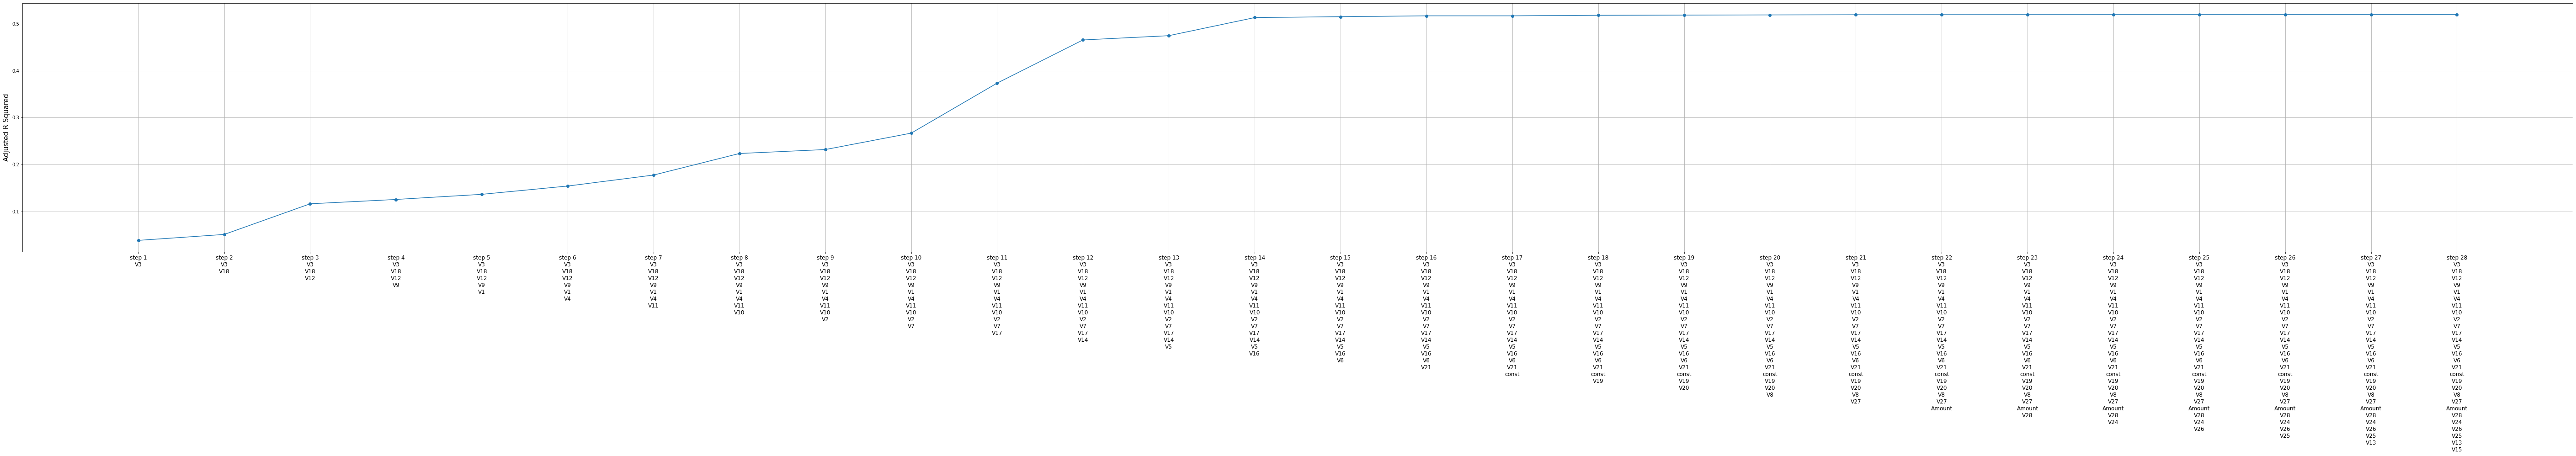

In [ ]:
selected_variables = stepwise_feature_selection(X_train, y_train)

In [ ]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Class   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     9140.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:53:54   Log-Likelihood:             4.8593e+05
No. Observations:              227845   AIC:                        -9.718e+05
Df Residuals:                  227817   BIC:                        -9.715e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
V3            -0.0051   4.77e-05   -105.922      0.0

# 분산을 이용한 방법
- 분산이 작은 데이터는 종속변수에 영향을 덜 줄것이다.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

In [ ]:
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [ ]:
selector.fit(df[cols])
print(selector.variances_)

[3.83647578e+00 2.72681045e+00 2.29902117e+00 2.00467678e+00
 1.90507436e+00 1.77494002e+00 1.53039520e+00 1.42647385e+00
 1.20698823e+00 1.18558965e+00 1.04185143e+00 9.98399911e-01
 9.90567315e-01 9.18902320e-01 8.37800459e-01 7.67816427e-01
 7.21370915e-01 7.02536891e-01 6.62659610e-01 5.94323307e-01
 5.39523633e-01 5.26640906e-01 3.89949292e-01 3.66807083e-01
 2.71729873e-01 2.32542076e-01 1.62918619e-01 1.08954579e-01
 2.56911600e+04]


In [ ]:
selector.set_params(threshold = 0.6)

VarianceThreshold(threshold=0.6)

In [ ]:
out_sel = selector.fit_transform(df[cols])

In [ ]:
print(selector.get_support())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False  True]


In [ ]:
df_sel = df.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,29]]
print(df_sel)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10       V11       V12       V13  \
0       0.239599  0.098698  0.363787  0.090794 -0.55160

# Xverse

In [ ]:
!pip install xverse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xverse.transformer import MonotonicBinning

clf = MonotonicBinning()
clf.fit(X,y)

print(clf.bins)

{'V1': array([-56.40750963,  -0.64058832,   1.17745441,   2.45492999]), 'V2': array([-72.71572756,  -0.33610107,   0.52057836,  22.05772899]), 'V3': array([-48.32558936,  -0.46615899,   0.72381818,   9.38255843]), 'V4': array([-5.6831712 , -0.60200567,  0.46154166, 16.87534403]), 'V5': array([-113.74330671,   -0.45540296,    0.36441505,   34.80166588]), 'V6': array([-26.16050594,  -0.60214379,   0.12549838,  73.30162555]), 'V7': array([-43.55724157,  -0.33384901,   0.35900823, 120.58949395]), 'V8': array([-73.21671846,  -0.12682399,   0.1973664 ,  20.00720837]), 'V9': array([-13.43406632,  -0.41295442,   0.35657093,  15.59499461]), 'V10': array([-24.58826244,  -0.36521231,   0.18997358,  23.74513612]), 'V11': array([-4.79747346, -0.51634955,  0.47323877, 12.01891318]), 'V12': array([-18.68371463,  -0.19434546,   0.45057524,   7.84839208]), 'V13': array([-5.79188121, -0.40655822,  0.40943392,  7.12688296]), 'V14': array([-19.21432549,  -0.24598182,   0.33113231,  10.52676605]), 'V15': a

In [ ]:
from xverse.transformer import WOE 

clf = WOE()
clf.fit(X,y)

print(clf.woe_df)

   Variable_Name           Category  Count  Event  Non_Event  Event_Rate  \
0             V1  (-56.409, -0.641]  94936    357      94579    0.003760   
1             V1    (-0.641, 1.177]  94935    104      94831    0.001095   
2             V1     (1.177, 2.455]  94936     31      94905    0.000327   
3             V2  (-72.717, -0.336]  94936     44      94892    0.000463   
4             V2    (-0.336, 0.521]  94935     30      94905    0.000316   
..           ...                ...    ...    ...        ...         ...   
82           V28   (-0.0321, 0.041]  94935     40      94895    0.000421   
83           V28    (0.041, 33.848]  94936    307      94629    0.003234   
84        Amount     (-0.001, 9.99]  97314    249      97065    0.002559   
85        Amount       (9.99, 50.0]  93731     57      93674    0.000608   
86        Amount   (50.0, 25691.16]  93762    186      93576    0.001984   

    Non_Event_Rate  Event_Distribution  Non_Event_Distribution       WOE  \
0         0

In [ ]:
print(clf.iv_df)

   Variable_Name  Information_Value
23            V4           2.463816
6            V14           2.184594
4            V12           2.040063
22            V3           1.740336
3            V11           1.716530
2            V10           1.644795
8            V16           1.271454
12            V2           1.270831
9            V17           1.112365
28            V9           1.041527
26            V7           1.001606
1             V1           0.813675
14           V21           0.755325
25            V6           0.585586
20           V27           0.556388
10           V18           0.547360
21           V28           0.544312
24            V5           0.500510
27            V8           0.421933
13           V20           0.404422
11           V19           0.384183
0         Amount           0.294884
16           V23           0.143636
17           V24           0.079793
19           V26           0.026704
5            V13           0.026584
18           V25           0

이론상 0.5~1을 의심하라고는 하지만 경험상 현업에서는 0.6이상 높은 값을 원한다.

즉, IV가 0.5이상인 변수는 다음과 같다.

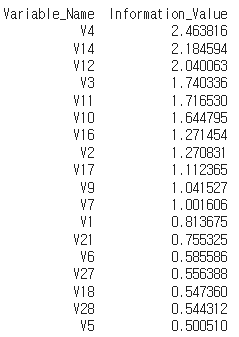


In [ ]:
clf.transform(X)  #apply WOE transformation on the dataset

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.779904,-1.700075,-2.211038,1.041017,-1.112025,-0.866765,-1.412288,-1.057937,-1.437626,-2.211027,...,0.615331,-1.387584,-0.076105,0.325745,-0.089372,-0.123326,-0.043687,0.694876,-1.412288,0.138577
1,-1.667285,-1.700075,-1.805467,-1.843218,-1.112025,-0.770054,-1.412288,-1.057937,-1.112035,-2.211027,...,-1.006612,-0.600841,-0.031018,0.082061,0.325745,-0.123326,-0.043687,-1.229882,-1.412288,0.393676
2,0.779904,-1.316946,-2.211038,-1.843218,0.676340,-0.866765,-1.057947,0.618636,0.891574,-1.604744,...,0.615331,0.791089,0.098806,0.082061,0.325745,-0.089382,-0.043687,-0.346786,-0.123337,0.138577
3,0.779904,-1.700075,-2.211038,-4.002955,-1.112025,-0.866765,-1.412288,0.618636,0.891574,-2.211027,...,-0.240427,-1.387584,-0.076105,0.325745,0.325745,0.183682,-0.043687,0.694876,0.628488,0.138577
4,0.779904,0.938295,-2.211038,-1.843218,-1.112025,-0.770054,-1.057947,-0.225021,-1.437626,-1.604744,...,0.615331,-1.387584,0.098806,0.325745,-0.089372,-0.123326,0.198827,0.694876,0.628488,0.138577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.779904,0.938295,1.005679,-4.002955,0.676340,0.751388,0.881456,0.618636,-1.437626,-1.604744,...,0.615331,0.791089,-0.076105,0.082061,0.325745,0.183682,0.198827,0.694876,0.628488,0.393676
284803,0.779904,-1.700075,-2.211038,-4.002955,-0.346786,-0.866765,-1.412288,0.618636,-1.437626,0.992102,...,0.615331,0.791089,0.098806,-0.634763,0.325745,-0.089382,-0.194901,0.694876,-0.123337,-1.045165
284804,-1.667285,-1.700075,1.005679,-1.843218,-0.346786,-0.866765,-1.412288,0.618636,-1.437626,0.992102,...,-1.006612,0.791089,0.098806,-0.634763,-0.355455,0.183682,-0.043687,-1.229882,-1.412288,0.138577
284805,-0.456101,0.938295,-1.805467,1.041017,-1.112025,-0.866765,0.881456,0.618636,-1.437626,0.992102,...,0.615331,0.791089,0.098806,0.325745,-0.089372,-0.089382,0.198827,0.694876,0.628488,-1.045165
